In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, pacf_yw
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox

Outliers detected in CPI: []


/var/folders/zs/ns2fd7h11h52z19x5rm7g55m0000gn/T/ipykernel_17664/1325780388.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/zs/ns2fd7h11h52z19x5rm7g55m0000gn/T/ipykernel_17664/1325780388.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


<Figure size 1000x400 with 0 Axes>

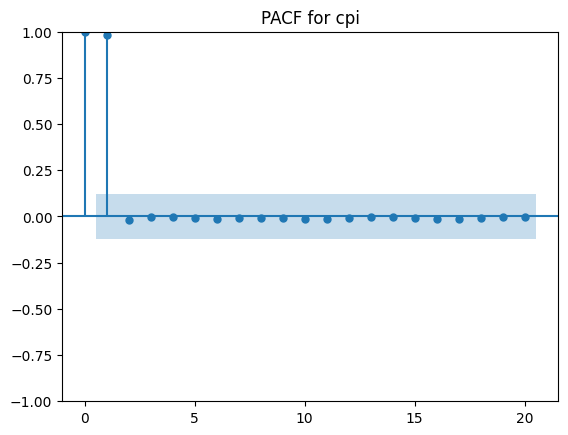

cpi: p-value = 0.9940441697395551
Non-stationary cpi differenced for stationarity


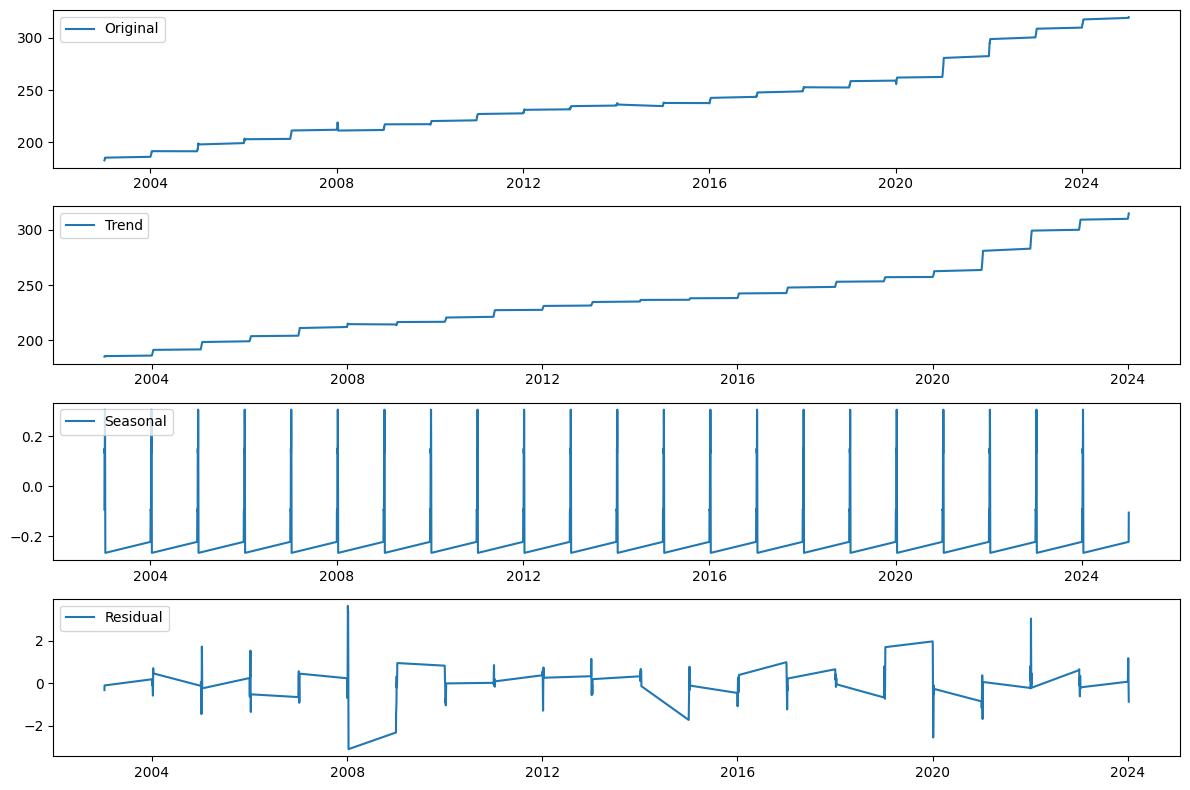

Ljung-Box Test Results for cpi Residuals:
       lb_stat     lb_pvalue
10  223.882027  1.644515e-42


<Figure size 1000x400 with 0 Axes>

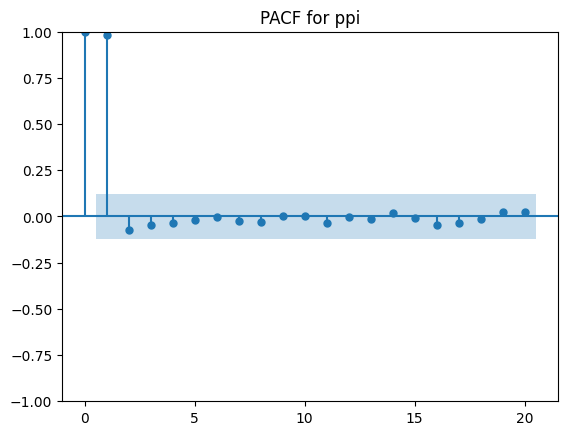

ppi: p-value = 0.7200687972441014
Non-stationary ppi differenced for stationarity


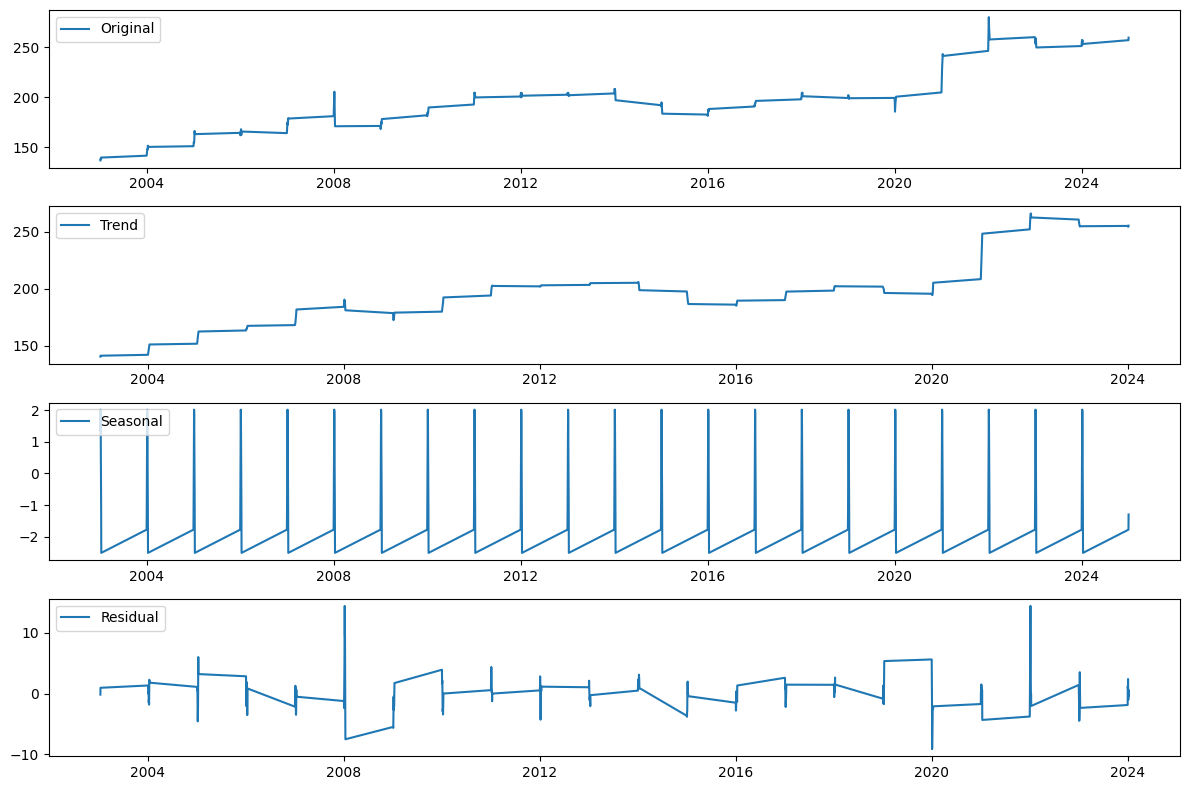

Ljung-Box Test Results for ppi Residuals:
       lb_stat     lb_pvalue
10  272.965389  7.929376e-53


<Figure size 1000x400 with 0 Axes>

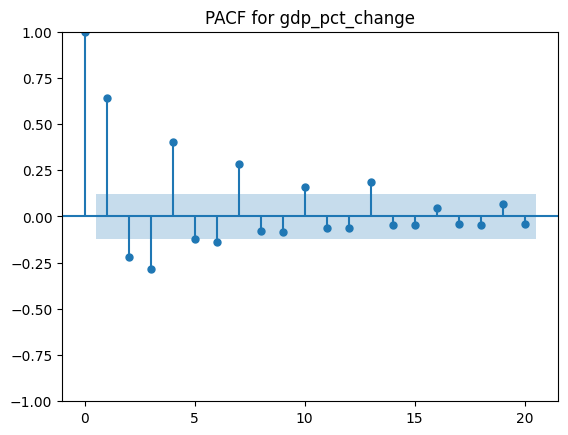

gdp_pct_change: p-value = 0.017850090765406286


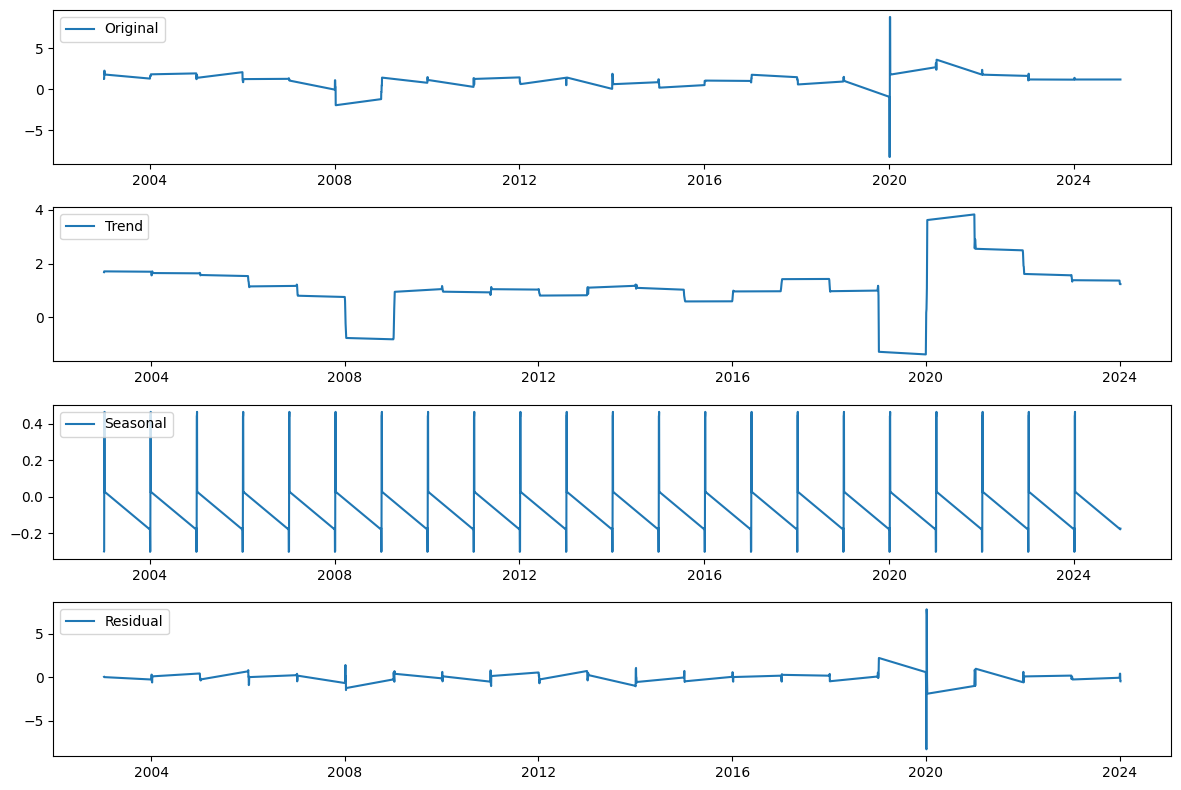

Ljung-Box Test Results for gdp_pct_change Residuals:
       lb_stat     lb_pvalue
10  225.958882  6.038791e-43


<Figure size 1000x400 with 0 Axes>

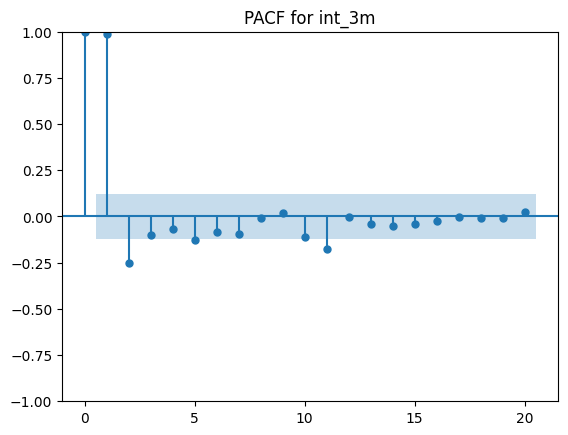

int_3m: p-value = 0.030517463353385493


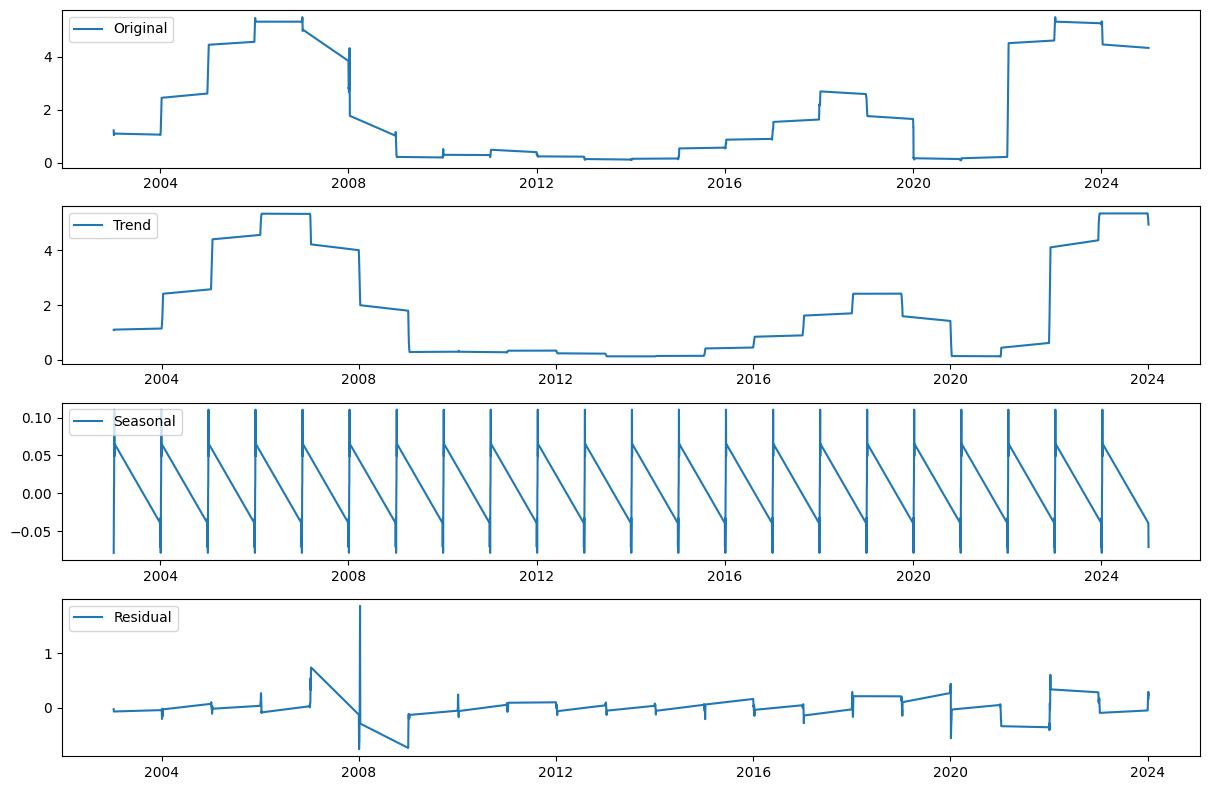

Ljung-Box Test Results for int_3m Residuals:
       lb_stat     lb_pvalue
10  227.773619  2.515684e-43


<Figure size 1000x400 with 0 Axes>

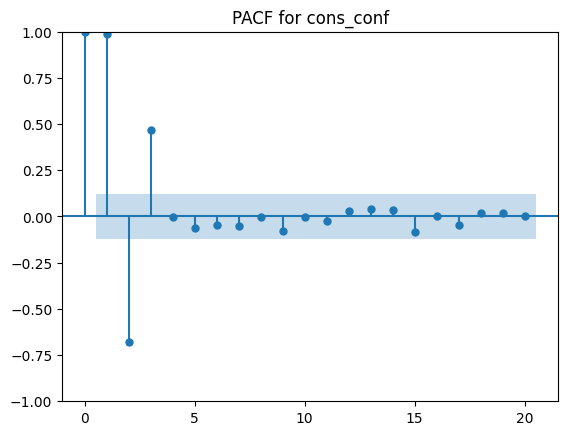

cons_conf: p-value = 0.2925696270799695
Non-stationary cons_conf differenced for stationarity


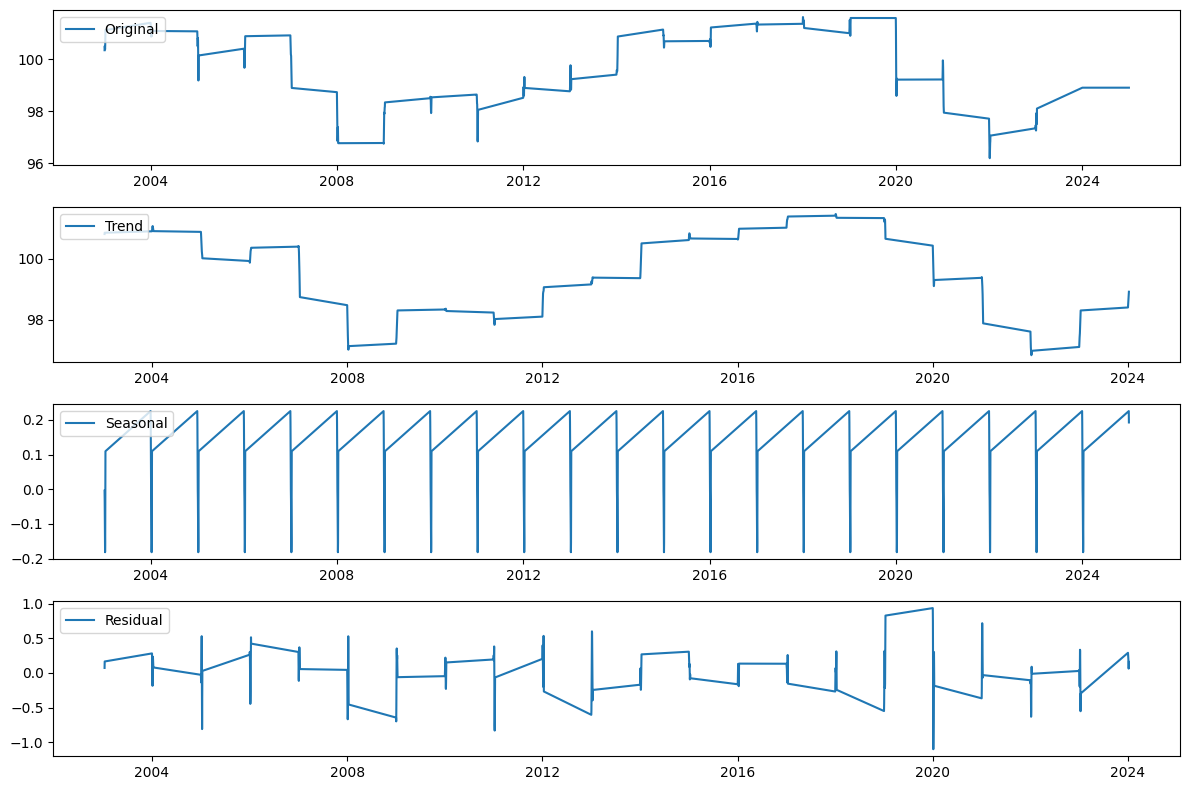

Ljung-Box Test Results for cons_conf Residuals:
       lb_stat     lb_pvalue
10  327.327719  2.558395e-64


<Figure size 1000x400 with 0 Axes>

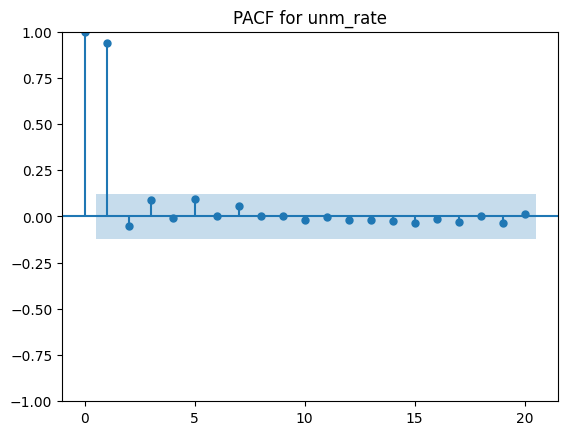

unm_rate: p-value = 0.06963239395842265
Non-stationary unm_rate differenced for stationarity


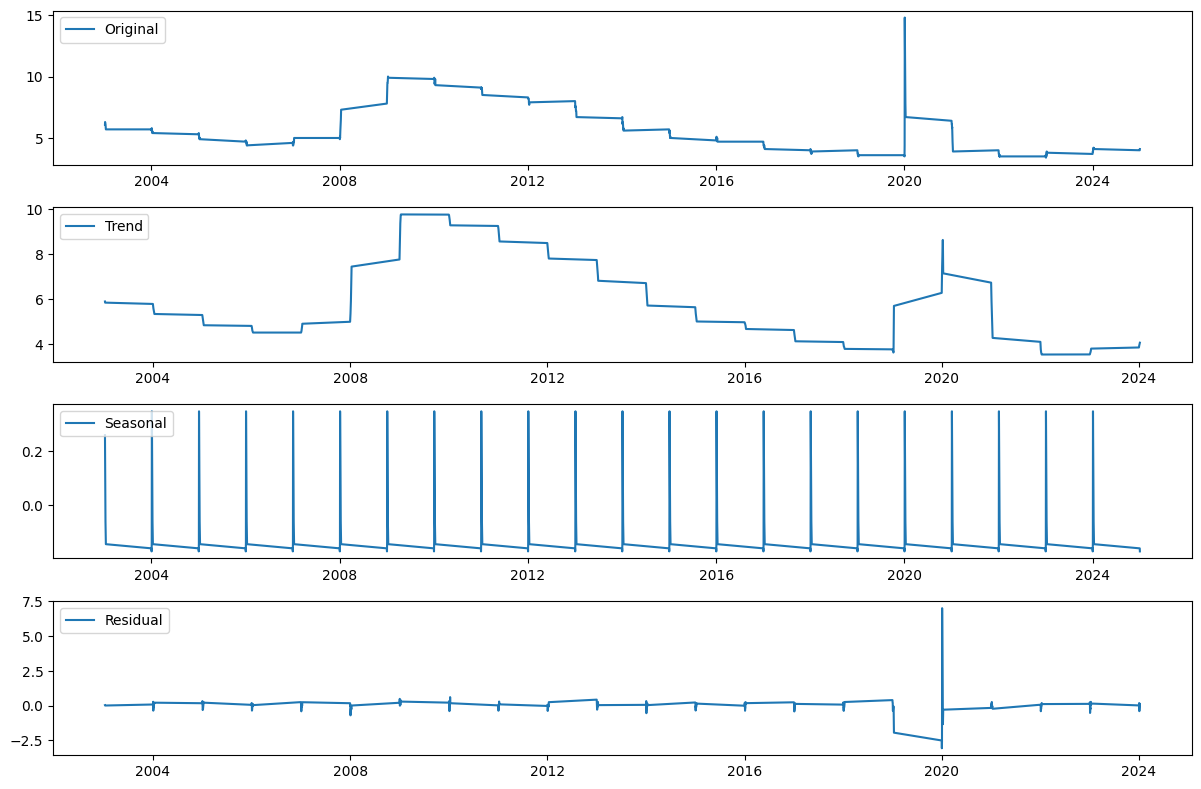

Ljung-Box Test Results for unm_rate Residuals:
       lb_stat     lb_pvalue
10  177.561824  7.512641e-33


In [13]:
def preprocess_data(df):
    """
    Clean and preprocess the DataFrame:
      - Convert 'date' column to datetime and set as index.
      - Interpolate missing values.
      - Identify outliers in CPI using the Z-score method.
      - Check stationarity of the series using the ADF test and plot the PACF.
      - Identify and visualize seasonal decomposition of each series.
      - Perform Ljung-Box test on residuals to check for any remaining autocorrelation.
    
    Parameters:
        df (DataFrame): Input DataFrame.
    
    Returns:
        df (DataFrame): Preprocessed DataFrame with new columns added.
    """
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

    # Handle missing values using forward fill for simplicity in this example
    df.fillna(method='ffill', inplace=True)

    # Identify outliers in the CPI column using Z-score (absolute z-score > 3 is considered an outlier)
    df['CPI_zscore'] = zscore(df['cpi'])
    df['CPI_outlier'] = df['CPI_zscore'].abs() > 3
    outliers = df[df['CPI_outlier']]  # Filter rows where CPI_outlier is True
    print("Outliers detected in CPI:", outliers.index.tolist())

    # Plot PACF for each macroeconomic variable including CPI
    variables = ['cpi', 'ppi', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']
    for var in variables:
        if var in df.columns:
            plt.figure(figsize=(10, 4))
            plot_pacf(df[var], lags=20, method='ywm')
            plt.title(f'PACF for {var}')
            plt.show()

            # Check for stationarity and differencing
            result = adfuller(df[var])
            print(f'{var}: p-value = {result[1]}')
            if result[1] > 0.05:  # if p-value > 0.05, series is not stationary
                df[f'{var}_diff'] = df[var].diff().dropna()
                print(f'Non-stationary {var} differenced for stationarity')

            # Seasonal Decomposition
            decomposition = seasonal_decompose(df[var], model='additive', period=12)  # Assuming monthly data with yearly seasonality
            df[f'{var}_trend'] = decomposition.trend
            df[f'{var}_seasonal'] = decomposition.seasonal
            df[f'{var}_resid'] = decomposition.resid

            plt.figure(figsize=(12, 8))
            plt.subplot(411)
            plt.plot(df[var], label='Original')
            plt.legend(loc='upper left')
            plt.subplot(412)
            plt.plot(decomposition.trend, label='Trend')
            plt.legend(loc='upper left')
            plt.subplot(413)
            plt.plot(decomposition.seasonal,label='Seasonal')
            plt.legend(loc='upper left')
            plt.subplot(414)
            plt.plot(decomposition.resid, label='Residual')
            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.show()

            # Ljung-Box Test on residuals to check for autocorrelation
            ljung_box_results = acorr_ljungbox(df[f'{var}_resid'].dropna(), lags=[10], return_df=True)
            print(f"Ljung-Box Test Results for {var} Residuals:")
            print(ljung_box_results)
    return df
# Example usage:
# Load your data into a DataFrame first, here's how you can load a CSV file:
df = pd.read_csv('US_consolidated_df.csv')
df_preprocessed = preprocess_data(df)
